In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Charger les notes
ratings = pd.read_csv(r"C:\Users\khadi\OneDrive\Bureau\desktop\mini\ml-100k\u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# Charger les films
movies = pd.read_csv(r"C:\Users\khadi\OneDrive\Bureau\desktop\mini\ml-100k\u.item", sep="|", encoding="latin-1", 
                     names=["movie_id", "title", "release_date", "video_release_date", "IMDb_URL",
                            "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
                            "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
                            "Romance", "Sci-Fi", "Thriller", "War", "Western"])

# Fusion des deux
data = pd.merge(ratings, movies[["movie_id", "title"]], on="movie_id")

print("Dimensions :", data.shape)
print(data.head())


Dimensions : (100000, 5)
   user_id  movie_id  rating  timestamp                       title
0      196       242       3  881250949                Kolya (1996)
1      186       302       3  891717742    L.A. Confidential (1997)
2       22       377       1  878887116         Heavyweights (1994)
3      244        51       2  880606923  Legends of the Fall (1994)
4      166       346       1  886397596         Jackie Brown (1997)


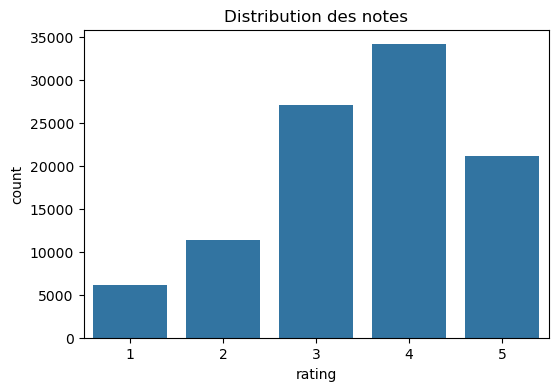

Films les plus notés :
 title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64
Films avec la meilleure moyenne :
 title
They Made Me a Criminal (1939)                       5.0
Marlene Dietrich: Shadow and Light (1996)            5.0
Saint of Fort Washington, The (1993)                 5.0
Someone Else's America (1995)                        5.0
Star Kid (1997)                                      5.0
Great Day in Harlem, A (1994)                        5.0
Aiqing wansui (1994)                                 5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
Entertaining Angels

In [10]:


# Distribution des notes
plt.figure(figsize=(6,4))
sns.countplot(data=data, x="rating")
plt.title("Distribution des notes")
plt.show()

# Films les plus notés
top_movies = data.groupby("title")["rating"].count().sort_values(ascending=False).head(10)
print("Films les plus notés :\n", top_movies)

# Moyenne des notes par film
mean_ratings = data.groupby("title")["rating"].mean().sort_values(ascending=False).head(10)
print("Films avec la meilleure moyenne :\n", mean_ratings)


### 1. Vérifier les valeurs manquantes



In [15]:
print(data.isnull().sum())


user_id      0
movie_id     0
rating       0
timestamp    0
title        0
dtype: int64


### 2. Supprimer les colonnes inutiles

In [18]:
genres_cols = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
               'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
               'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies_clean = movies[['movie_id', 'title'] + genres_cols]


### 3. Conversion des genres en vecteurs

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

# Matrice des genres
genre_matrix = movies_clean[genres_cols].values

# Similarité cosinus entre films
similarity_matrix = cosine_similarity(genre_matrix)


### 4. Création d’un dictionnaire pour accéder aux films facilement


In [24]:
# Index des films par titre
indices = pd.Series(movies_clean.index, index=movies_clean['title']).drop_duplicates()


### 5. Fonction de recommandation

In [26]:
def recommend_similar(movie_title, top_n=5):
    try:
        # Trouver l'index du film
        idx = indices[movie_title]

        # Récupérer les similarités pour ce film
        sim_scores = list(enumerate(similarity_matrix[idx]))

        # Trier par similarité décroissante (sauf le film lui-même)
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]

        # Récupérer les indices des films recommandés
        movie_indices = [i[0] for i in sim_scores]

        # Retourner les titres
        return movies_clean['title'].iloc[movie_indices].tolist()
    
    except KeyError:
        return "Film non trouvé dans le dataset."


#### Test Rapide


In [32]:
print(recommend_similar("Star Wars (1977)", top_n=5))

['Return of the Jedi (1983)', 'Empire Strikes Back, The (1980)', 'Starship Troopers (1997)', 'African Queen, The (1951)', 'Stargate (1994)']


## Étape 5 : Collaborative Filtering (User-User)

In [37]:
# Moyenne des notes si doublons
ratings_unique = data.groupby(['user_id', 'title'], as_index=False)['rating'].mean()
user_movie_matrix = ratings_unique.pivot(index='user_id', columns='title', values='rating').fillna(0)


In [39]:
from sklearn.metrics.pairwise import cosine_similarity

# Similarité entre utilisateurs
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Fonction pour recommander des films à un utilisateur
def recommend_for_user(user_id, top_n=5):
    if user_id not in user_movie_matrix.index:
        return "Utilisateur non trouvé."

    # Scores pondérés par similarité
    sim_scores = user_similarity_df[user_id]
    weighted_ratings = user_movie_matrix.T.dot(sim_scores) / sim_scores.sum()

    # Supprimer les films déjà vus
    watched = user_movie_matrix.loc[user_id]
    recommendations = weighted_ratings[watched == 0]

    # Top films recommandés
    top_recs = recommendations.sort_values(ascending=False).head(top_n)
    return top_recs.index.tolist()


#### Test rapide

In [42]:
print(recommend_for_user(1, top_n=5))


["Schindler's List (1993)", 'E.T. the Extra-Terrestrial (1982)', "One Flew Over the Cuckoo's Nest (1975)", 'English Patient, The (1996)', 'Scream (1996)']


In [46]:
import streamlit as st

# Tout le code ML doit être dans le notebook (précédentes cellules)
# Pas besoin d'importer recommender.py
st.title("🎬 Mini Recommender System")

# Content-Based
film = st.selectbox("Choisis un film :", movies_clean['title'].tolist())
if st.button("Recommander par film"):
    recs = recommend_similar(film)
    for r in recs:
        st.write("-", r)

# Collaborative Filtering
user_id = st.number_input("Entrez l'ID utilisateur :", min_value=1, max_value=943)
if st.button("Recommander par utilisateur"):
    recs = recommend_for_user(user_id)
    for r in recs:
        st.write("-", r)


2025-09-10 21:38:21.843 
  command:

    streamlit run C:\Users\khadi\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-10 21:38:21.846 Session state does not function when running a script without `streamlit run`
